In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re


In the previous chapter we explored ways to visualize the overlap of distributions. These we simulated by generating clouds of points directly, with predetermined size and shape (covariance along 3 axes). We then varyied the distances that separated them. At each variation, we captured their pdfs and compared their values at a fixed number of coordinates (our observations).

This exercise, while fun, is only really relevant if your original data consists of three dimensional coordinates. We might be used to see structure in our data, it is another thing to show that it could acquire the shapes that would allow for the visualizations we developped.

In this post we shall create our clouds of points from frequency vectors, each encasing the probabilities of binary occurences. These are our real populations. 

We will begin by generating these vectors in the same way we did in **1. Generating Haplotypes**, by varying the parameters _a_ and _b_ of the theta distribution and sampling from there.

In [2]:

# We must first define the number of populations, the length of the haplotypes desired, and their respective population sizes
L= 300

import itertools as it
n= 20
n_samples= 20

a_range= np.linspace(1.5,2.5,n_samples)
a_set= [i for i in a_range for _ in range(n)]

b_range= np.linspace(0.1,.6,n_samples)
b_set= [i for i in b_range for _ in range(n)]

L_set= [L] * n * n_samples

traces= [x for x in it.product(range(n*11),range(n*11),range(n*11))]

background= np.array([a_set,b_set,L_set]).T

vector_lib= []
for k in range(background.shape[0]):
    
    probs= beta.rvs(background[k,0], background[k,1], size=int(background[k,2]))
    probs[(probs > 1)]= 1
    probs= [1-x for x in probs]
    
    
    vector_lib.append(probs)

vector_lib= np.array(vector_lib)



We will now reduce the dimensions of this data. However, in this case we don't expect to find structure. We created our vectors randomly within our ranges. This feature space will be used solely to retrieve new vectors through inverse transformation following operations that are not limited to 3 dimensions. Thus, we will try to keep as much of the information as possible for that transformation.

In [3]:
n_comp = 50

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')
features = pca.fit_transform(vector_lib)

print("; ".join(['PC{0}: {1}'.format(x+1,round(pca.explained_variance_ratio_[x],3)) for x in range(n_comp)]))
print('features shape: {}'.format(features.shape))

PC1: 0.047; PC2: 0.011; PC3: 0.011; PC4: 0.011; PC5: 0.01; PC6: 0.01; PC7: 0.01; PC8: 0.01; PC9: 0.01; PC10: 0.01; PC11: 0.01; PC12: 0.009; PC13: 0.009; PC14: 0.009; PC15: 0.009; PC16: 0.009; PC17: 0.009; PC18: 0.009; PC19: 0.009; PC20: 0.008; PC21: 0.008; PC22: 0.008; PC23: 0.008; PC24: 0.008; PC25: 0.008; PC26: 0.008; PC27: 0.008; PC28: 0.008; PC29: 0.008; PC30: 0.008; PC31: 0.007; PC32: 0.007; PC33: 0.007; PC34: 0.007; PC35: 0.007; PC36: 0.007; PC37: 0.007; PC38: 0.007; PC39: 0.007; PC40: 0.007; PC41: 0.007; PC42: 0.007; PC43: 0.007; PC44: 0.006; PC45: 0.006; PC46: 0.006; PC47: 0.006; PC48: 0.006; PC49: 0.006; PC50: 0.006
features shape: (400, 50)


In [4]:
#### Let's plot the first 3 coordinates nonetheless.
####
fig_data= [go.Scatter3d(
        x = features[:,0],
        y = features[:,1],
        z = features[:,2],
        type='scatter3d',
        mode= "markers",
        text= ['a: {}; b: {}, L: {}; index = {}'.format(background[k,0],background[k,1],background[k,2], k) for k in range(background.shape[0])],
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
    )]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


By hovering above the points, we see that variation along the first axis is usually correlated with the _a_ and _b_ parameters of the beta distribution.

**[Note]** If you played around with these parameters you will have noticed the beta distribution becomes less skewed as they rise. Although this relation is not linear, it will generally translate into vectors with a larger number of higher frequencies.

Other considerations aside, we will chose a number of populations from among these - i have set this number to 3. To change it, add or remove from the list 'Pops' and modify the list 'Sizes' as well.

The next block of code will calculate global and pairwise Fsts among the populations chosen. Modify your choice until you are happy with these values, i don't really have a better way to inform this choice right now.


In [5]:
#### calculating Fsts between populations.
Pops= [395,390,211]
Sizes= [80,100,30]

def return_fsts(vector_lib,pops):
    H= {pop: [1-(vector_lib[pop,x]**2 + (1 - vector_lib[pop,x])**2) for x in range(vector_lib.shape[1])] for pop in pops}
    Store= []
    for comb in it.combinations(pops,2):
        P= [sum([vector_lib[x,i] for x in comb]) / len(comb) for i in range(vector_lib.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        Fst= np.mean([(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x] for x in range(len(P))])
        
        Store.append([comb,Fst])
    
    ### total fst:
    P= [sum([vector_lib[x,i] for x in pops]) / len(pops) for i in range(vector_lib.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst']),FST

Pairwise, Total_fst= return_fsts(vector_lib,Pops)

print('global fst: {}'.format(round(Total_fst,4)))
Pairwise

global fst: 0.1419


,pops,fst
0,"(395, 390)",0.089852
1,"(395, 211)",0.103709
2,"(390, 211)",0.101696


Finally, for capturing regions of overlap between our populations.

We will pick two populations from among our choices and we will make their distance vary in the feature space of frequency vectors. We will do this by once again resorting to the sinusoid of their distance.

At each variation, we will calculate the pairwise fsts among all our populations. we will also store the distances separating our vectors in feature space. We will plot these values against each other afterwards.

We will first need to slightly modify our **return_fsts** function. Fsts of loci with 0 variation will be set to 0. This will still produce a runtime warning as it first attemps to divide by 0. Stay calm.

In [6]:
#### We'll have to first change our fst function.

def return_fsts2(freq_array):
    pops= range(freq_array.shape[0])
    H= {pop: [1-(freq_array[pop,x]**2 + (1 - freq_array[pop,x])**2) for x in range(freq_array.shape[1])] for pop in range(freq_array.shape[0])}
    Store= []

    for comb in it.combinations(H.keys(),2):
        P= [sum([freq_array[x,i] for x in comb]) / len(comb) for i in range(freq_array.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        per_locus_fst= [[(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x],0][int(HT[x] == 0)] for x in range(len(P))]
        per_locus_fst= np.nan_to_num(per_locus_fst)
        Fst= np.mean(per_locus_fst)

        Store.append([comb,Fst])
    
    
    ### total fst:
    P= [sum([freq_array[x,i] for x in pops]) / len(pops) for i in range(freq_array.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst'])


In [7]:
#### We're going to do something different now. We'll have two points get closer together in time.
#first chose two
target= [1,2]


labels= []
Fsts_crawl= []
angle_list= []
Distances_crawl= []

for angle in np.arange(1,30,.1):
    coords= features[Pops,:]
    vector2= coords[target[1]] - coords[target[0]]

    coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    
    new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    new_freqs[new_freqs > 1] = 1
    new_freqs[new_freqs < 0] = 0
    
    Pairwise= return_fsts2(new_freqs)
    
    Distances= []
    for train in it.combinations([x for x in range(new_freqs.shape[0])],2):
        Distances.append(np.sqrt((coords[train[0]][0] - coords[train[1]][0])**2 + (coords[train[0]][1] - coords[train[1]][1])**2) + (coords[train[0]][2] - coords[train[1]][2])**2)
    Distances_crawl.extend(Distances)
    
    labels.extend(Pairwise.pops)
    
    Fsts_crawl.extend(Pairwise.fst)
    angle_list.extend([angle] * Pairwise.shape[0])


Control= np.array([angle_list,Fsts_crawl]).T

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



In [8]:
fig_data= [go.Scatter(
x= Distances_crawl,
y= Fsts_crawl,
mode= 'markers',
name= 'fst vs distances'
)
]

layout = go.Layout(
    title= 'Fst vs. distance in vector feature space',
    yaxis=dict(
        title='fsts'),
    xaxis=dict(
        title='eucledian distance in feature space')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

We can see that distances in feature space aren't linearly correlated to among-population fsts. This is to be expected. However the relationship is globally positive, i'll take that as a win and procede.

In [9]:
coords= {z:[x for x in range(len(labels)) if labels[x] == z] for z in list(set(labels))}

fig_data= [go.Scatter(
x= Control[coords[i],0],
y= Control[coords[i],1],
mode= 'lines',
name= 'fst pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]

layout = go.Layout(
    title= 'pairwise Fsts as a function of variable X',
    yaxis=dict(
        title='between population Fst'),
    xaxis=dict(
        title='X')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [10]:
coords= {z:[x for x in range(len(labels)) if labels[x] == z] for z in list(set(labels))}

fig_data= [go.Scatter(
x= [sin(x) for x in Control[coords[i],0]],
y= Control[coords[i],1],
mode= 'lines',
name= 'fst pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]

layout = go.Layout(
    title= 'pairwise Fsts against the sinusoid of variable X',
    yaxis=dict(
        title='between population Fst'),
    xaxis=dict(
        title='sin(X)')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

Globally, we learn that distances in feature space are indeed related to the amount of differentiation among our populations. 

Now we will will perform the same exercice, but at each step we will draw haplotypes from our vectors. We will then reduce the dimensionality of our haplotype data set, and estimate the kernel density of each population in that space.

The values of each KDE at the coordinates of our drawn observations (haplotypes) will be extracted.

In [11]:
labels= [0,1,2]

label_vector= np.repeat(np.array([x for x in labels]),Sizes)
label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in labels}

Windows= recursively_default_dict()

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in list(set(label_vector))}
threshold= .005
P= 30

def extract_profiles(global_data,target_ind_dict):
    ## estimate the bandwith
    params = {'bandwidth': np.linspace(np.min(global_data), np.max(global_data),20)}
    grid = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params,verbose=0)
    
    cluster_profiles= {x:[] for x in target_ind_dict.keys()}
    
    
    ## perform MeanShift clustering.
    combine= {}
    for bull in target_ind_dict.keys():
        Quanted_set= global_data[target_ind_dict[bull],:]
        grid.fit(Quanted_set)
        kde = grid.best_estimator_

        P_dist = kde.score_samples(Quanted_set)
        Fist = kde.score_samples(global_data)

        ## Normalizing log-likelihood estimates by those of the reference set.
        Fist = scipy.stats.norm(np.mean(P_dist),np.std(P_dist)).cdf(Fist)
        cluster_profiles[bull].append(Fist)

    
    return cluster_profiles
    

for angle in np.arange(1,30,.1):
    coords= features[Pops,:]
    vector2= coords[target[1]] - coords[target[0]]

    coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    #new_freqs= vector_lib[Pops,:]
    new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])


    N_pops= len(Pops)
    
    labels= np.repeat(np.array([x for x in range(N_pops)]),Sizes)

    data= []

    for k in range(N_pops):

        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        m= Sizes[k]
        Haps= [[np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)] for acc in range(m)]

        data.extend(Haps)
    
    data= np.array(data)
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')

    data= pca2.fit_transform(data)

    profiles= extract_profiles(data,label_indicies)
    
    ### store stuff.
    Windows[int(angle*1000)]= profiles


Windows= {1:Windows}

To wrap up we will classify each observation according to the KDE values it received at every step.

We will allow for pure, intermediate and outlier classes.

We will plot these classifications in the form of an ideogram and resort to the same color sceme as in the previous post. 


**pure classes**:
- pop1: red
- pop2: yellow
- pop3: blue

**Intermediate classes**
- pop0-pop1: orange
- pop1-pop2: green
- pop0-pop2: purple
- pop0-pop1-pop2: silver

Assignments at varying steps of X will be plotted as a global ideogram.

-  Comparison_threshold= 5
-  Outlier_threshold= 1e-4


The next block contains only functions and can be skipped. if not interested in the code, you may jump directly to the end of the page.

In [47]:

def Merge_class(Ref_profiles,focus_indicies,Out,Diff_threshold,X_threshold):
    Blocks_genome = recursively_default_dict()
    
    for CHR in Ref_profiles.keys():
        print(CHR)
        Points = sorted(Out[CHR].keys())
        Likes = Ref_profiles[CHR]
        N_pops= len(Likes[[x for x in Likes.keys()][0]])
        Pop_labels= Likes[[x for x in Likes.keys()][0]].keys()
        print("number of reference populations: {0}".format(N_pops))
        Likes = {x:[Likes[bl][x] for bl in sorted(Likes.keys())] for x in Pop_labels}
        Likes = {x:np.array([y[0] for y in Likes[x]]) for x in Likes.keys()}

        Topo = []
        
        #range_Parents = [x + Aro.shape[0] for x in range(Daddy.shape[0])]
        #range_Crossed = [x for x in range(Aro.shape[0])]
        
        for acc in focus_indicies:
            Guys = np.array([Likes[x][:,acc] for x in Pop_labels])
            Guys = np.nan_to_num(Guys)
            Guys = [[[y,0][int(y<=X_threshold)] for y in x] for x in Guys]
            
            Test = [int(x <= X_threshold) for x in np.amax(np.array(Guys),axis = 0)]     
            
            #
            Guys = np.array(Guys).T
            
            maxim = np.argmax(Guys,axis = 1)
            where_X = [x for x in range(Guys.shape[0]) if Test[x] == 1]
            
            #
            Consex = [x for x in it.combinations(range(N_pops),2)]
            if Consex:
                for h in range(len(maxim)):
                    CL = []
                    for j in Consex:
                        Diff = Guys[h,j]
                        if maxim[h] not in j or len([x for x in Diff if x < X_threshold]) > 0:
                            continue
                        if max(Diff) <= X_threshold:
                            Diff = 0
                        else:
#                            Diff = 1 - int(len([x for x in Diff if x >= X_threshold]) == 2)
                            Diff = abs(max(Diff)) / abs(min(Diff))
                            Diff = int(Diff > Diff_threshold)
                        
                        if Diff == 0:
                            CL.append(j)
                    
                    if len(CL) == 2:
                        maxim[h] = 7
                    if len(CL) == 1:
                        maxim[h] = sum(CL[0]) + N_pops
            
            maxim[where_X] = N_pops
            
            if not Consex:
                for h in range(len(maxim)):
                    maxim[h] = int(10*Guys[h,0])    
            
            
            Topo.append(maxim + 1)
        
        
        Topo = np.array(Topo).T
        
        Clove = {CHR:{Points[x]:Topo[x,] for x in range(len(Points))}}
        
        Blocks_genome.update(Clove)
    
    return Blocks_genome


def compress_ideo(df,chromosome_list):
    
    new_set = []
    
    for CHR in range(len(chromosome_list)):
        
        Chr = int(re.search('Region_(.+?)_',chromosome_list[CHR]).group(1))
        sub = df[df.chrom == chromosome_list[CHR]]
        Coordinates = sorted(sub.start)
        Size = sub.shape[0]
        start = min(df.start)
        First = sub.gieStain.iloc[0]
        for index in range(len(Coordinates)):
            row = sub[sub.start == Coordinates[index]]
            if index == 0:
                continue
            if index == (Size - 1):
                if row.gieStain.iloc[0] == First:
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
                else:
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
                    First = row.gieStain.iloc[0]
                    start = row.start.iloc[0]
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
            else:
                if row.gieStain.iloc[0] == First:
                    continue
                else:
                    new_set.append([chromosome_list[CHR],start,row.start.iloc[0]-1,First])
                    First = row.gieStain.iloc[0]
                    start = row.start.iloc[0]
    
    new_set = pd.DataFrame(new_set,columns = ['chrom', 'start', 'end', 'gieStain'])
    return new_set


# Here's the function that we'll call for each dataframe (once for chromosome
# ideograms, once for genes).  The rest of this script will be prepping data
# for input to this function
#
def chromosome_collections(df, y_positions, height,  **kwargs):
    """
    Yields BrokenBarHCollection of features that can be added to an Axes
    object.
    Parameters
    ----------
    df : pandas.DataFrame
        Must at least have columns ['chrom', 'start', 'end', 'color']. If no
        column 'width', it will be calculated from start/end.
    y_positions : dict
        Keys are chromosomes, values are y-value at which to anchor the
        BrokenBarHCollection
    height : float
        Height of each BrokenBarHCollection
    Additional kwargs are passed to BrokenBarHCollection
    """
    del_width = False
    if 'width' not in df.columns:
        del_width = True
        df['width'] = df['end'] - df['start']
    for chrom, group in df.groupby('chrom'):
        
        yrange = (y_positions[chrom], height)
        xranges = group[['start', 'width']].values
        yield BrokenBarHCollection(
            xranges, yrange, facecolors=group['colors'], **kwargs)
    if del_width:
        del df['width']


def return_ideogram(ideo, out= True):
    # Height of each ideogram
    chrom_height = 1

    # Spacing between consecutive ideograms
    chrom_spacing = 0

    # Height of the gene track. Should be smaller than `chrom_spacing` in order to
    # fit correctly
    gene_height = 0.0

    # Padding between the top of a gene track and its corresponding ideogram
    gene_padding = 0.0


    # Keep track of the y positions for ideograms and genes for each chromosome,
    # and the center of each ideogram (which is where we'll put the ytick labels)
    ybase = 0
    chrom_ybase = {}
    gene_ybase = {}
    chrom_centers = {}

    # Iterate in reverse so that items in the beginning of `chromosome_list` will
    # appear at the top of the plot
    for chrom in chromosome_list[::-1]:
        chrom_ybase[chrom] = ybase
        chrom_centers[chrom] = ybase + chrom_height / 2.
        gene_ybase[chrom] = ybase - gene_height - gene_padding
        ybase += chrom_height + chrom_spacing



    # Keep track of the y positions for ideograms and genes for each chromosome,
    # and the center of each ideogram (which is where we'll put the ytick labels)
    ybase = 0
    chrom_ybase = {}
    gene_ybase = {}
    chrom_centers = {}

    # Iterate in reverse so that items in the beginning of `chromosome_list` will
    # appear at the top of the plot
    for chrom in chromosome_list[::-1]:
        chrom_ybase[chrom] = ybase
        chrom_centers[chrom] = ybase + chrom_height / 2.
        gene_ybase[chrom] = ybase - gene_height - gene_padding
        ybase += chrom_height + chrom_spacing
    

    # Colors for different chromosome stains
    color_lookup = {
        'red': [255, 0, 0],
        'yellow': [255, 255, 0],
        'blue': [0, 0, 255],
        'orange': [255, 165, 0],
        'green': [50, 205, 50],
        'black': [0, 0, 0],
        'purple': [128, 0, 128],
        'silver': [211, 211, 211],
    }

    # Add a new column for colors
    
    ideo['colors'] = ideo['gieStain'].apply(lambda x: tuple([round(y / float(255),1) for y in color_lookup[x]]))
    # Add a new column for width
    ideo['width'] = ideo.end - ideo.start

    # Width, height (in inches)
    figsize = (10, 30)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    # Now all we have to do is call our function for the ideogram data...
    print("adding ideograms...")
    for collection in chromosome_collections(ideo, chrom_ybase, chrom_height, edgecolors=None, linewidths= 0):
        ax.add_collection(collection)

    # Axes tweaking
    ax.set_xticks([x for x in range(min(ideo.start),max(ideo.end),int(1000))])
    plt.xticks(fontsize = 5,rotation = 90)
    ax.tick_params(axis = 'x',pad = 10)

    ax.tick_params(axis='y', which='major', pad=30)
    ax.set_yticks([chrom_centers[i] for i in chromosome_list])
    ax.set_yticklabels(chromosome_list, fontsize = 5)
    ax.axis('tight')
    if out == True:
        plt.savefig('Ideo_step_' + '_OutlierTh' + str(Outlier_threshold) + '_Z' +str(Comparison_threshold)+ '.png',bbox_inches = 'tight')
    return fig



In [23]:
Out= {y:{x:x + 99 for x in Windows[y].keys()} for y in Windows.keys()}
focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 0
Outlier_threshold= 1e-4
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

1
number of reference populations: 3


In [24]:
chromosome_list = []

Ideo = []

chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks[Chr][bl][here] - 1]] for bl in sorted(Blocks[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo.extend(Stock)


In [25]:

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list)


adding ideograms...


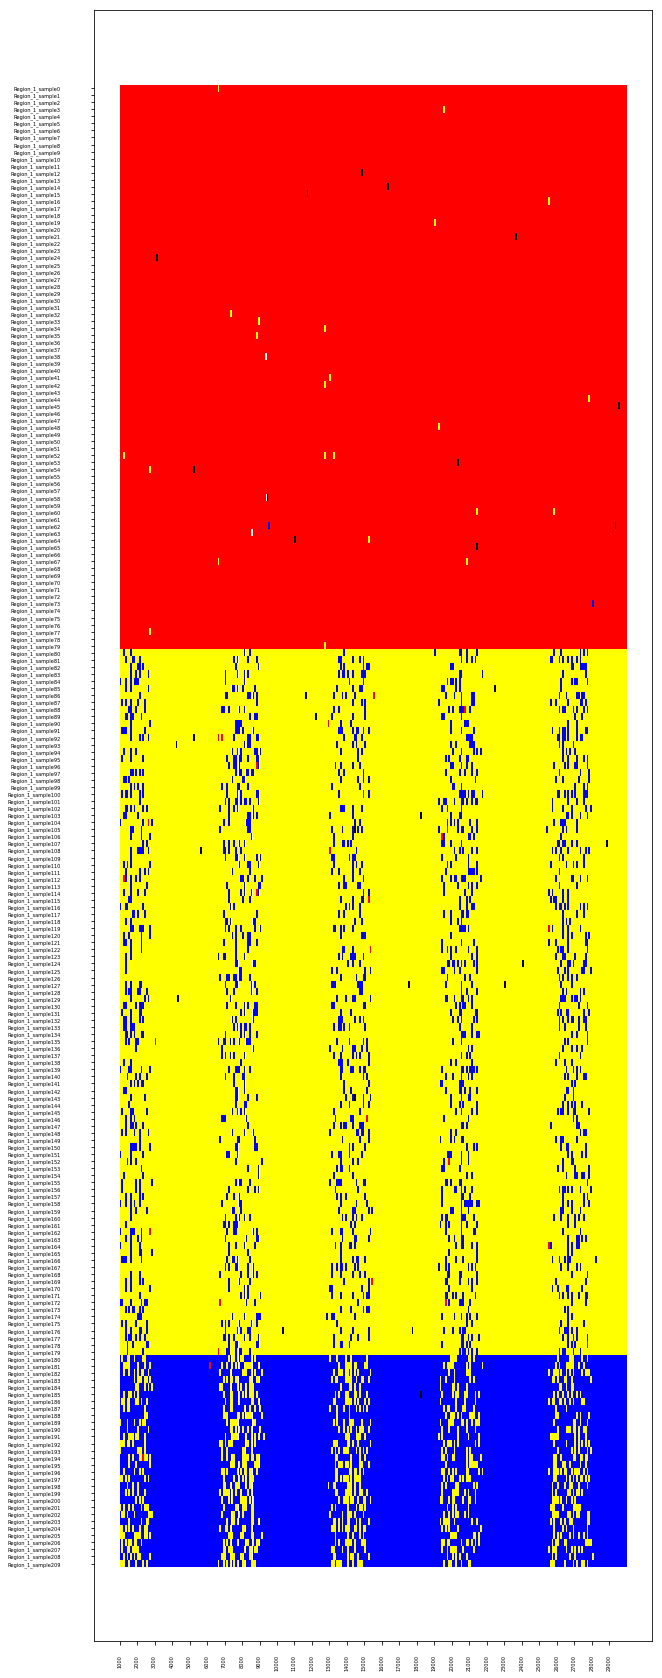

In [26]:
fig= return_ideogram(ideo)


In [42]:
wind= []
Proportions= []
labs= []
for w in Windows[1].keys():
    for combo in it.combinations(Windows[1][w].keys(),2):
        diffs= [abs(Windows[1][w][combo[0]][x] - Windows[1][w][combo[1]][x]) for x in range(len(Windows[1][w][combo[1]]))]
        
        Proportions.append(np.mean(diffs))
        labs.append(combo)
        wind.append(w)


In [46]:
coords= {z:[x for x in range(len(labs)) if labs[x] == z] for z in list(set(labs))}


fig_data= [go.Scatter(
y= [Proportions[x] for x in coords[i]],
x= [wind[x] for x in coords[i]],
mode= 'lines',
name= ' pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]

layout = go.Layout(
    title= 'average KDE score differences',
    yaxis=dict(
        title='Difference'),
    xaxis=dict(
        title='X')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

1
number of reference populations: 3
adding ideograms...


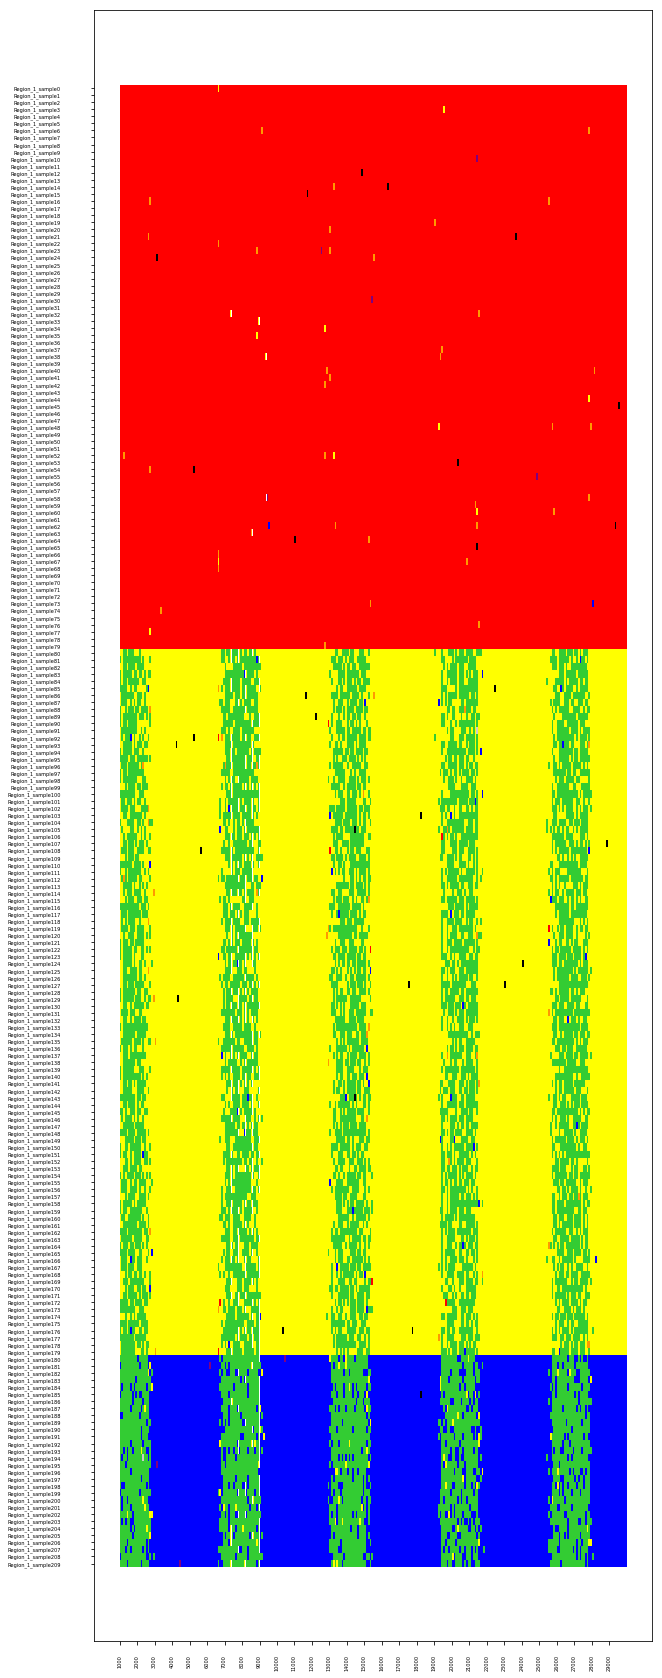

In [49]:
Comparison_threshold= 5
Outlier_threshold= 1e-4
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

chromosome_list = []

Ideo = []

chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks[Chr][bl][here] - 1]] for bl in sorted(Blocks[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo.extend(Stock)

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list)

fig= return_ideogram(ideo)
